AWS AI가 개발한 AutoGluon은 머신러닝 작업을 자동화하여 애플리케이션에서 강력한 예측 성능을 쉽게 달성할 수 있도록 지원합니다. 단 몇 줄의 코드만으로 이미지, 텍스트, 시계열 및 테이블 형식 데이터에 대해 높은 정확도의 머신러닝 및 딥러닝 모델을 학습하고 배포할 수 있습니다.


- 빠른 프로토타이핑: 몇 줄의 코드로 원시 데이터에 대한 머신러닝 솔루션을 구축합니다.
- 최첨단 기술: 전문가 지식 없이도 자동으로 SOTA 모델을 활용합니다.
- 쉬운 배포: 클라우드 예측기 및 사전 빌드된 컨테이너를 사용하여 실험에서 프로덕션으로 전환합니다.
- 사용자 정의 가능: 사용자 정의 기능 처리, 모델 및 메트릭으로 확장 가능합니다.

# 설치

AutoGluon은 Python 3.9 - 3.12을 지원되며 Linux, MacOS 및 Windows에서 사용할 수 있습니다. 다음과 같이 [uv](https://github.com/astral-sh/uv)를 사용해 AutoGluon을 설치할 수 있습니다:

```bash
uv add autogluon
```

GPU 지원, Conda 설치 및 선택적 종속성을 포함한 자세한 지침은 아래를 참조하십시오.

- https://auto.gluon.ai/stable/install.html
- https://github.com/autogluon/autogluon


In [ ]:
import os
import warnings

import numpy as np

warnings.filterwarnings("ignore")
np.random.seed(42)

# 테이블 형식 데이터 예측

AutoGluon의 `TabularPredictor`를 사용하여 테이블 형식 데이터셋의 다른 열을 기반으로 대상 열의 값을 예측하는 방법을 알아봅니다. 먼저 AutoGluon이 설치되었는지 확인한 다음 AutoGluon의 `TabularDataset`과 `TabularPredictor`를 가져옵니다. 전자는 데이터를 로드하는 데 사용하고 후자는 모델을 학습하고 예측하는 데 사용합니다.

In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor

## 예제 데이터

이 튜토리얼에서는 [Nature 7887호](https://www.nature.com/nature/volumes/600/issues/7887)의 커버 스토리인 [수학 정리에 대한 AI 기반 직관](https://www.nature.com/articles/s41586-021-04086-x.pdf)의 데이터셋을 사용합니다. 목표는 매듭의 속성을 기반으로 매듭의 시그니처를 예측하는 것입니다. [원본 데이터](https://github.com/deepmind/mathematics_conjectures/blob/main/knot_theory.ipynb)에서 10K개의 학습 예제와 5K개의 테스트 예제를 샘플링했습니다. 샘플링된 데이터셋을 사용하면 이 튜토리얼을 빠르게 실행할 수 있지만, 원한다면 AutoGluon은 전체 데이터셋도 처리할 수 있습니다.

이 데이터셋을 URL에서 직접 로드합니다. AutoGluon의 `TabularDataset`은 pandas [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)의 하위 클래스이므로 모든 `DataFrame` 메서드를 `TabularDataset`에서도 사용할 수 있습니다.

In [ ]:
data_url = "https://raw.githubusercontent.com/mli/ag-docs/main/knot_theory/"
train_data = TabularDataset(f"{data_url}train.csv")
train_data.head()

,Unnamed: 0,chern_simons,cusp_volume,hyperbolic_adjoint_torsion_degree,hyperbolic_torsion_degree,injectivity_radius,longitudinal_translation,meridinal_translation_imag,meridinal_translation_real,short_geodesic_imag_part,short_geodesic_real_part,Symmetry_0,Symmetry_D3,Symmetry_D4,Symmetry_D6,Symmetry_D8,Symmetry_Z/2 + Z/2,volume,signature
0,70746,0.090530,12.226322,0,10,0.507756,10.685555,1.144192,-0.519157,-2.760601,1.015512,0.0,0.0,0.0,0.0,0.0,1.0,11.393225,-2
1,240827,0.232453,13.800773,0,14,0.413645,10.453156,1.320249,-0.158522,-3.013258,0.827289,0.0,0.0,0.0,0.0,0.0,1.0,12.742782,0
2,155659,-0.144099,14.761030,0,14,0.436928,13.405199,1.101142,0.768894,2.233106,0.873856,0.0,0.0,0.0,0.0,0.0,0.0,15.236505,2
3,239963,-0.171668,13.738019,0,22,0.249481,27.819496,0.493827,-1.188718,-2.042771,0.498961,0.0,0.0,0.0,0.0,0.0,0.0,17.279890,-8
4,90504,0.235188,15.896359,0,10,0.389329,15.330971,1.036879,0.722828,-3.056138,0.778658,0.0,0.0,0.0,0.0,0.0,0.0,16.749298,4


우리의 목표는 18개의 고유한 정수를 가진 "signature" 열에 저장됩니다. pandas가 이 데이터 유형을 범주형으로 올바르게 인식하지 못했지만 AutoGluon이 이 문제를 해결할 것입니다.

In [ ]:
label = "signature"
train_data[label].describe()

count    10000.000000
mean        -0.022000
std          3.025166
min        -12.000000
25%         -2.000000
50%          0.000000
75%          2.000000
max         12.000000
Name: signature, dtype: float64

## 학습

이제 레이블 열 이름을 지정하여 `TabularPredictor`를 구성한 다음 `TabularPredictor.fit()`으로 데이터셋에 대해 학습합니다. 다른 매개변수를 지정할 필요가 없습니다. AutoGluon은 이것이 다중 클래스 분류 작업임을 인식하고, 자동 특성 공학을 수행하고, 여러 모델을 학습한 다음, 모델을 앙상블하여 최종 예측기를 생성합니다.

In [ ]:
predictor = TabularPredictor(label=label, verbosity=0).fit(train_data)

모델 학습은 CPU에 따라 몇 분 또는 그 이하가 소요됩니다. `time_limit` 인수를 지정하여 학습 속도를 높일 수 있습니다. 예를 들어, `fit(..., time_limit=60)`은 60초 후에 학습을 중지합니다. 일반적으로 시간 제한이 길수록 예측 성능이 향상되며, 시간 제한이 너무 낮으면 AutoGluon이 합리적인 모델 세트를 학습하고 앙상블하는 것을 방해합니다.



## 예측

학습 데이터셋에 대해 학습된 예측기가 있으면 예측 및 평가에 사용할 별도의 데이터 세트를 로드할 수 있습니다.

In [ ]:
test_data = TabularDataset(f"{data_url}test.csv")

y_pred = predictor.predict(test_data.drop(columns=[label]))
y_pred.head()

0   -4
1    0
2    0
3    4
4    2
Name: signature, dtype: int64

## 평가

`evaluate()` 함수를 사용하여 테스트 데이터셋에서 예측기를 평가할 수 있습니다. 이 함수는 모델 학습에 사용되지 않은 데이터에 대해 예측기가 얼마나 잘 수행되는지 측정합니다.

In [ ]:
predictor.evaluate(test_data, silent=True)

{'accuracy': 0.9482,
 'balanced_accuracy': np.float64(0.7448082022363894),
 'mcc': np.float64(0.936511530000817)}

AutoGluon의 `TabularPredictor`는 또한 `leaderboard()` 함수를 제공하여 테스트 데이터에 대한 각 개별 학습 모델의 성능을 평가할 수 있습니다.

In [ ]:
predictor.leaderboard(test_data)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.9482,0.964965,accuracy,0.498636,0.403077,8.703081,0.004810,0.000391,0.042636,2,True,14
1,LightGBM,0.9456,0.955956,accuracy,0.019126,0.003349,1.833650,0.019126,0.003349,1.833650,1,True,5
2,XGBoost,0.9448,0.956957,accuracy,0.095466,0.010777,3.124414,0.095466,0.010777,3.124414,1,True,11
3,LightGBMLarge,0.9444,0.949950,accuracy,0.077716,0.014079,5.836701,0.077716,0.014079,5.836701,1,True,13
4,CatBoost,0.9432,0.955956,accuracy,0.024575,0.002570,7.570538,0.024575,0.002570,7.570538,1,True,8
5,RandomForestEntr,0.9384,0.949950,accuracy,0.189795,0.174759,0.604675,0.189795,0.174759,0.604675,1,True,7
6,NeuralNetFastAI,0.9376,0.944945,accuracy,0.053981,0.005054,3.912081,0.053981,0.005054,3.912081,1,True,3
7,ExtraTreesGini,0.9360,0.946947,accuracy,0.154584,0.212095,1.019274,0.154584,0.212095,1.019274,1,True,9
8,ExtraTreesEntr,0.9358,0.942943,accuracy,0.165139,0.191926,0.821660,0.165139,0.191926,0.821660,1,True,10
9,NeuralNetTorch,0.9352,0.949950,accuracy,0.013011,0.003917,126.092729,0.013011,0.003917,126.092729,1,True,12


# 멀티모달 데이터 예측

AutoGluon의 `MultiModalPredictor`는 이미지, 텍스트, 테이블 형식 데이터를 포함한 입력을 위해 최첨단 딥러닝 모델을 자동으로 구축할 수 있는 모델 동물원의 딥러닝 모델 동물원입니다. 데이터를 AutoGluon의 멀티모달 데이터프레임 형식으로 변환하면 `MultiModalPredictor`가 다른 기능을 기반으로 한 열의 값을 예측할 수 있습니다.

## 예제 데이터

이 튜토리얼에서는 [PetFinder 데이터셋](https://www.kaggle.com/c/petfinder-adoption-prediction)의 단순화 및 서브샘플링된 버전을 사용합니다. 목표는 입양 프로필을 기반으로 애완동물 입양률을 예측하는 것입니다. 이 단순화된 버전에서 입양 속도는 0(느림)과 1(빠름)의 두 가지 범주로 그룹화됩니다. 먼저 petfinder 데이터셋이 포함된 zip 파일을 다운로드하고 현재 작업 디렉토리에 압축을 풉니다.

In [ ]:
from autogluon.core.utils.loaders import load_zip

download_dir = "./ag_multimodal_tutorial"
zip_file = "https://automl-mm-bench.s3.amazonaws.com/petfinder_for_tutorial.zip"

load_zip.unzip(zip_file, unzip_dir=download_dir)

다음으로, pandas를 사용하여 데이터셋의 CSV 파일을 `DataFrames`으로 읽어들입니다. 예측하려는 열은 "AdoptionSpeed"입니다.

In [ ]:
import pandas as pd

dataset_path = f"{download_dir}/petfinder_for_tutorial"

train_data = pd.read_csv(f"{dataset_path}/train.csv", index_col=0)
test_data = pd.read_csv(f"{dataset_path}/test.csv", index_col=0)

label_col = "AdoptionSpeed"
image_col = "Images"

train_data[image_col] = train_data[image_col].apply(lambda ele: ele.split(";")[0])
test_data[image_col] = test_data[image_col].apply(lambda ele: ele.split(";")[0])


def path_expander(path, base_folder):
    path_l = path.split(";")
    return ";".join([os.path.abspath(os.path.join(base_folder, path)) for path in path_l])


train_data[image_col] = train_data[image_col].apply(
    lambda ele: path_expander(ele, base_folder=dataset_path)
)
test_data[image_col] = test_data[image_col].apply(
    lambda ele: path_expander(ele, base_folder=dataset_path)
)

PetFinder 데이터셋에는 이미지 디렉토리가 있으며, 데이터의 일부 레코드에는 여러 이미지가 연결되어 있습니다. AutoGluon의 멀티모달 데이터프레임 형식에서는 이미지 열에 단일 이미지 파일 경로인 문자열이 포함되어야 합니다. 이 예에서는 이미지 특성 열을 첫 번째 이미지로만 제한하고 현재 디렉토리 구조에 맞게 모든 것을 올바르게 설정하기 위해 약간의 경로 조작이 필요합니다.

각 동물의 입양 프로필에는 사진, 텍스트 설명, 나이, 품종, 이름, 색상 등과 같은 다양한 테이블 형식 특성이 포함됩니다. 예제 데이터 행의 사진과 설명을 살펴보겠습니다.

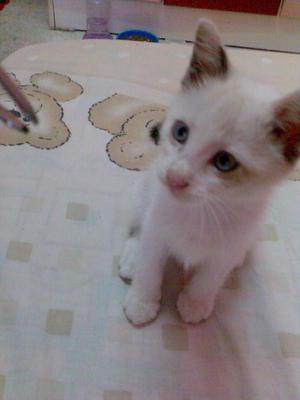

"I rescued Yumi Hamasaki at a food stall far away in Kelantan. At that time i was on my way back to KL, she was suffer from stomach problem and looking very2 sick.. I send her to vet & get the treatment + vaccinated and right now she's very2 healthy.. About yumi : - love to sleep with ppl - she will keep on meowing if she's hugry - very2 active, always seeking for people to accompany her playing - well trained (poo+pee in her own potty) - easy to bathing - I only feed her with these brands : IAMS, Kittenbites, Pro-formance Reason why i need someone to adopt Yumi: I just married and need to move to a new house where no pets are allowed :( As Yumi is very2 special to me, i will only give her to ppl that i think could take care of her just like i did (especially on her foods things).."

In [ ]:
from IPython.display import Image, display

example_row = train_data.iloc[0]
example_image = example_row[image_col]

pil_img = Image(filename=example_image)
display(pil_img)

example_row["Description"]

## 학습

이제 데이터가 적절한 형식이 되었으므로 학습 데이터에 대해 `MultiModalPredictor`를 학습시킬 수 있습니다. 여기서는 이 빠른 데모를 위해 짧은 학습 시간 예산을 설정합니다. 학습 시간이 길수록 예측 성능이 향상되지만 짧은 시간 안에 놀라울 정도로 좋은 성능을 얻을 수 있습니다.

In [ ]:
from autogluon.multimodal import MultiModalPredictor

predictor = MultiModalPredictor(label=label_col, verbosity=0).fit(
    train_data=train_data, time_limit=120
)

INFO: Seed set to 0
INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name              | Type                | Params | Mode 
------------------------------------------------------------------
0 | model             | MultimodalFusionMLP | 207 M  | train
1 | validation_metric | BinaryAUROC         | 0      | train
2 | loss_func         | CrossEntropyLoss    | 0      | train
------------------------------------------------------------

Epoch 0:  50%|█████     | 30/60 [00:03<00:03,  8.10it/s]                   

INFO: Epoch 0, global step 1: 'val_roc_auc' reached 0.56208 (best 0.56208), saving model to '/mnt/c4a1c56d-0589-48cd-9717-f6c33a86fa3b/Tools/learn_autogluon/AutogluonModels/ag-20250718_065554/epoch=0-step=1.ckpt' as top 3


Epoch 0: 100%|██████████| 60/60 [00:12<00:00,  4.99it/s]

INFO: Epoch 0, global step 4: 'val_roc_auc' reached 0.75111 (best 0.75111), saving model to '/mnt/c4a1c56d-0589-48cd-9717-f6c33a86fa3b/Tools/learn_autogluon/AutogluonModels/ag-20250718_065554/epoch=0-step=4.ckpt' as top 3


Epoch 1:  50%|█████     | 30/60 [00:02<00:02, 11.48it/s]

INFO: Epoch 1, global step 5: 'val_roc_auc' reached 0.76056 (best 0.76056), saving model to '/mnt/c4a1c56d-0589-48cd-9717-f6c33a86fa3b/Tools/learn_autogluon/AutogluonModels/ag-20250718_065554/epoch=1-step=5.ckpt' as top 3


Epoch 1: 100%|██████████| 60/60 [00:11<00:00,  5.39it/s]

INFO: Epoch 1, global step 8: 'val_roc_auc' reached 0.78417 (best 0.78417), saving model to '/mnt/c4a1c56d-0589-48cd-9717-f6c33a86fa3b/Tools/learn_autogluon/AutogluonModels/ag-20250718_065554/epoch=1-step=8.ckpt' as top 3


Epoch 2:  50%|█████     | 30/60 [00:02<00:02, 11.62it/s]

INFO: Epoch 2, global step 9: 'val_roc_auc' reached 0.78306 (best 0.78417), saving model to '/mnt/c4a1c56d-0589-48cd-9717-f6c33a86fa3b/Tools/learn_autogluon/AutogluonModels/ag-20250718_065554/epoch=2-step=9.ckpt' as top 3


Epoch 2: 100%|██████████| 60/60 [00:11<00:00,  5.27it/s]

INFO: Epoch 2, global step 12: 'val_roc_auc' reached 0.79056 (best 0.79056), saving model to '/mnt/c4a1c56d-0589-48cd-9717-f6c33a86fa3b/Tools/learn_autogluon/AutogluonModels/ag-20250718_065554/epoch=2-step=12.ckpt' as top 3


Epoch 3:  50%|█████     | 30/60 [00:02<00:02, 11.77it/s]

INFO: Epoch 3, global step 13: 'val_roc_auc' reached 0.78417 (best 0.79056), saving model to '/mnt/c4a1c56d-0589-48cd-9717-f6c33a86fa3b/Tools/learn_autogluon/AutogluonModels/ag-20250718_065554/epoch=3-step=13.ckpt' as top 3


Epoch 3: 100%|██████████| 60/60 [00:11<00:00,  5.36it/s]

INFO: Epoch 3, global step 16: 'val_roc_auc' reached 0.78806 (best 0.79056), saving model to '/mnt/c4a1c56d-0589-48cd-9717-f6c33a86fa3b/Tools/learn_autogluon/AutogluonModels/ag-20250718_065554/epoch=3-step=16.ckpt' as top 3


Epoch 4:  50%|█████     | 30/60 [00:02<00:02, 11.22it/s]

INFO: Epoch 4, global step 17: 'val_roc_auc' reached 0.79222 (best 0.79222), saving model to '/mnt/c4a1c56d-0589-48cd-9717-f6c33a86fa3b/Tools/learn_autogluon/AutogluonModels/ag-20250718_065554/epoch=4-step=17.ckpt' as top 3


Epoch 4: 100%|██████████| 60/60 [00:11<00:00,  5.13it/s]

INFO: Epoch 4, global step 20: 'val_roc_auc' reached 0.79111 (best 0.79222), saving model to '/mnt/c4a1c56d-0589-48cd-9717-f6c33a86fa3b/Tools/learn_autogluon/AutogluonModels/ag-20250718_065554/epoch=4-step=20.ckpt' as top 3


Epoch 5:  50%|█████     | 30/60 [00:02<00:02, 11.55it/s]

INFO: Epoch 5, global step 21: 'val_roc_auc' was not in top 3


Epoch 5: 100%|██████████| 60/60 [00:08<00:00,  7.18it/s]

INFO: Epoch 5, global step 24: 'val_roc_auc' reached 0.80014 (best 0.80014), saving model to '/mnt/c4a1c56d-0589-48cd-9717-f6c33a86fa3b/Tools/learn_autogluon/AutogluonModels/ag-20250718_065554/epoch=5-step=24.ckpt' as top 3


Epoch 6:  50%|█████     | 30/60 [00:02<00:02, 11.40it/s]

INFO: Epoch 6, global step 25: 'val_roc_auc' reached 0.79764 (best 0.80014), saving model to '/mnt/c4a1c56d-0589-48cd-9717-f6c33a86fa3b/Tools/learn_autogluon/AutogluonModels/ag-20250718_065554/epoch=6-step=25.ckpt' as top 3


Epoch 6: 100%|██████████| 60/60 [00:11<00:00,  5.26it/s]

INFO: Epoch 6, global step 28: 'val_roc_auc' was not in top 3


Epoch 7:  50%|█████     | 30/60 [00:02<00:02, 11.35it/s]

INFO: Epoch 7, global step 29: 'val_roc_auc' was not in top 3
INFO: Time limit reached. Elapsed time is 0:02:02. Signaling Trainer to stop.


Epoch 7:  52%|█████▏    | 31/60 [00:06<00:05,  4.98it/s]


INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00,  8.12it/s]


INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00,  8.38it/s]


INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00,  8.34it/s]


내부적으로 `MultiModalPredictor`는 문제 유형(분류 또는 회귀)을 자동으로 유추하고, 특성 양식을 감지하고, 멀티모달 모델 풀에서 모델을 선택하고, 선택된 모델을 학습합니다. 여러 백본이 사용되는 경우 MultiModalPredictor는 그 위에 후기 융합 모델(MLP 또는 트랜스포머)을 추가합니다.

## 예측

모델을 학습시킨 후, 이를 사용하여 보류된 테스트 데이터셋의 레이블을 예측합니다.

In [ ]:
predictions = predictor.predict(test_data.drop(columns=label_col))
predictions[:5]

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 11.89it/s]


8     0
70    1
82    1
28    0
63    1
Name: AdoptionSpeed, dtype: int64

분류 작업의 경우 각 출력 클래스에 대한 예측 확률을 쉽게 얻을 수 있습니다.

In [ ]:
probs = predictor.predict_proba(test_data.drop(columns=label_col))
probs[:5]

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 12.30it/s]


,0,1
8,0.998383,0.001617
70,0.000966,0.999034
82,0.000547,0.999453
28,0.999870,0.000130
63,0.005271,0.994729


## 평가

마지막으로, 보류된 테스트 데이터셋에서 다른 성능 메트릭, 이 경우 [roc_auc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)에 대해 예측기를 평가할 수 있습니다.

In [ ]:
scores = predictor.evaluate(test_data, metrics=["roc_auc"])
scores

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 11.93it/s]


{'roc_auc': np.float64(0.8976)}

# 시계열 데이터 예측

간단한 `fit()` 호출을 통해 AutoGluon은 다음을 학습하고 조정할 수 있습니다.

- 간단한 예측 모델 (예: ARIMA, ETS, Theta),
- 강력한 딥러닝 모델 (예: DeepAR, Temporal Fusion Transformer),
- 트리 기반 모델 (예: LightGBM),
- 다른 모델의 예측을 결합하는 앙상블

이를 통해 단변량 시계열 데이터에 대한 다단계 _확률적_ 예측을 생성합니다.

이 튜토리얼에서는 AutoGluon을 사용하여 [M4 예측 대회](https://www.sciencedirect.com/science/article/pii/S0169207019301128) 데이터셋에 대한 시간별 예측을 빠르게 생성하는 방법을 보여줍니다.

## 시계열 데이터를 `TimeSeriesDataFrame`으로 로드하기

먼저 필요한 모듈을 가져옵니다.

In [ ]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

`autogluon.timeseries`를 사용하려면 다음 두 클래스만 필요합니다:

- `TimeSeriesDataFrame`은 여러 시계열로 구성된 데이터셋을 저장합니다.
- `TimeSeriesPredictor`는 최상의 예측 모델을 피팅, 튜닝 및 선택하고 새로운 예측을 생성하는 작업을 처리합니다.

M4 시간별 데이터셋의 하위 집합을 `pandas.DataFrame`으로 로드합니다.

In [ ]:
df = pd.read_csv(
    "https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_subset/train.csv"
)
df.head()

,item_id,timestamp,target
0,H1,1750-01-01 00:00:00,605.0
1,H1,1750-01-01 01:00:00,586.0
2,H1,1750-01-01 02:00:00,586.0
3,H1,1750-01-01 03:00:00,559.0
4,H1,1750-01-01 04:00:00,511.0


AutoGluon은 시계열 데이터를 [long format](https://doc.dataiku.com/dss/latest/time-series/data-formatting.html#long-format)으로 예상합니다.
데이터 프레임의 각 행에는 다음으로 표시되는 단일 시계열의 단일 관측(타임스텝)이 포함됩니다.

- 시계열의 고유 ID(`"item_id"`) (int 또는 str)
- 관측의 타임스탬프(`"timestamp"`) (`pandas.Timestamp` 또는 호환 형식)
- 시계열의 숫자 값(`"target"`)

원본 데이터셋은 항상 고유 ID, 타임스탬프 및 대상 값에 대한 최소 세 개의 열이 있는 이 형식을 따라야 하지만 이러한 열의 이름은 임의로 지정할 수 있습니다.
그러나 AutoGluon에서 사용하는 `TimeSeriesDataFrame`을 구성할 때 열 이름을 제공하는 것이 중요합니다.
데이터가 예상 형식과 일치하지 않으면 AutoGluon에서 예외가 발생합니다.

In [ ]:
train_data = TimeSeriesDataFrame.from_data_frame(
    df, id_column="item_id", timestamp_column="timestamp"
)
train_data.head()

target
item_id timestamp                  
H1      1750-01-01 00:00:00   605.0
        1750-01-01 01:00:00   586.0
        1750-01-01 02:00:00   586.0
        1750-01-01 03:00:00   559.0
        1750-01-01 04:00:00   511.0

`TimeSeriesDataFrame`에 저장된 각 개별 시계열을 _item_이라고 합니다. 예를 들어, 항목은 수요 예측의 다른 제품에 해당하거나 금융 데이터셋의 다른 주식에 해당할 수 있습니다. 이 설정은 시계열의 _패널_이라고도 합니다. 이것은 다변량 예측과 동일하지 않습니다. AutoGluon은 다른 항목(시계열) 간의 상호 작용을 모델링하지 않고 각 시계열에 대해 개별적으로 예측을 생성합니다.

`TimeSeriesDataFrame`은 [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html)에서 상속되므로 `pandas.DataFrame`의 모든 속성과 메서드를 `TimeSeriesDataFrame`에서 사용할 수 있습니다. 또한 다양한 데이터 형식에 대한 로더와 같은 다른 유틸리티 기능도 제공합니다.

## `TimeSeriesPredictor.fit`으로 시계열 모델 학습

시계열의 미래 값을 예측하려면 `TimeSeriesPredictor` 객체를 만들어야 합니다. `autogluon.timeseries`의 모델은 시계열을 미래의 _여러 단계_로 예측합니다. 우리는 작업에 따라 이러한 단계의 수, 즉 _예측 길이_(_예측 기간_이라고도 함)를 선택합니다. 예를 들어 우리 데이터셋에는 시간별 _빈도_로 측정된 시계열이 포함되어 있으므로 `prediction_length = 48`로 설정하여 미래 48시간까지 예측하는 모델을 학습합니다.

AutoGluon에 학습된 모델을 `./autogluon-m4-hourly` 폴더에 저장하도록 지시합니다. 또한 AutoGluon이 [평균 절대 스케일 오차(MASE)](https://en.wikipedia.org/wiki/Mean_absolute_scaled_error)에 따라 모델 순위를 매겨야 하며 예측하려는 데이터가 `TimeSeriesDataFrame`의 `"target"` 열에 저장되도록 지정합니다.

In [ ]:
predictor = TimeSeriesPredictor(
    prediction_length=48,
    path="autogluon-m4-hourly",
    target="target",
    eval_metric="MASE",
    verbosity=0,
)

predictor.fit(train_data, presets="medium_quality", time_limit=600)

여기서는 `"medium_quality"` 사전 설정을 사용하고 학습 시간을 10분(600초)으로 제한했습니다. 사전 설정은 AutoGluon이 학습할 모델에 대한 파라미터를 정의합니다. `medium_quality` 사전 설정의 경우 다음과 같습니다.

- 간단한 기준선(`Naive`, `SeasonalNaive`)
- 통계 모델(`ETS`, `Theta`)
- LightGBM 기반 트리 기반 모델(`RecursiveTabular`, `DirectTabular`)
- 딥러닝 모델 `TemporalFusionTransformer`
- 그리고 이들을 결합한 가중 앙상블입니다.

`TimeSeriesPredictor`에 사용할 수 있는 다른 사전 설정은

- `"fast_training"`, `"high_quality"` 및 `"best_quality"` 등이 있습니다.

> 사전 설정들은 일반적으로 더 정확한 예측을 생성하지만 학습하는 데 시간이 더 오래 걸립니다.

AutoGluon은 `fit()` 을 통해 주어진 시간 제한 내에서 가능한 한 많은 모델을 학습합니다. 그런 다음 학습된 모델은 내부 검증 세트에서의 성능을 기반으로 순위가 매겨집니다. 기본적으로 이 검증 세트는 `train_data`의 각 시계열에서 마지막 `prediction_length` 타임스텝을 제외하여 구성됩니다.

## `TimeSeriesPredictor.predict`로 예측 생성

이제 학습된 `TimeSeriesPredictor`를 사용하여 미래 시계열 값을 예측할 수 있습니다. 기본적으로 AutoGluon은 내부 검증 세트에서 가장 좋은 점수를 받은 모델을 사용하여 예측합니다. 예측에는 항상 `train_data`의 각 시계열 끝에서 시작하여 다음 `prediction_length` 타임스텝에 대한 예측이 포함됩니다.

In [ ]:
predictions = predictor.predict(train_data)
predictions.head()

mean         0.1         0.2         0.3  \
item_id timestamp                                                             
H1      1750-01-30 04:00:00  622.354942  598.425139  606.981886  613.221995   
        1750-01-30 05:00:00  563.318481  537.515631  547.162459  553.498017   
        1750-01-30 06:00:00  521.525187  494.325763  504.013476  511.095175   
        1750-01-30 07:00:00  490.088652  461.432323  471.588108  478.747585   
        1750-01-30 08:00:00  465.376269  435.200758  445.454704  452.924012   

                                    0.4         0.5         0.6         0.7  \
item_id timestamp                                                             
H1      1750-01-30 04:00:00  617.991382  622.354942  627.043820  631.702888   
        1750-01-30 05:00:00  558.639161  563.318481  567.705346  572.642124   
        1750-01-30 06:00:00  516.550982  521.525187  526.583225  532.032613   
        1750-01-30 07:00:00  484.678311  490.088652  495.704356  501.733837   
        1750-01-30 08:00:00  459.572474  465.376269  470.925032  477.133554   

                                    0.8         0.9  
item_id timestamp                                    
H1      1750-01-30 04:00:00  637.264877  645.002394  
        1750-01-30 05:00:00  578.556409  587.001385  
        1750-01-30 06:00:00  538.334244  547.525425  
        1750-01-30 07:00:00  508.553248  519.106916  
        1750-01-30 08:00:00  484.607983  495.218336

AutoGluon은 _확률적_ 예측을 생성합니다. 미래의 시계열의 평균(기대값)을 예측하는 것 외에도 모델은 예측 분포의 분위수를 제공합니다.
분위수 예측은 가능한 결과의 범위에 대한 아이디어를 제공합니다.
예를 들어, `"0.1"` 분위수가 `500.0`과 같으면 모델은 대상 값이 `500.0` 미만일 확률이 10%라고 예측합니다.

이제 데이터셋의 시계열 중 하나에 대한 예측과 실제 관측값을 시각화합니다.
잠재적 결과의 범위를 표시하기 위해 평균 예측과 10% 및 90% 분위수를 플로팅합니다.

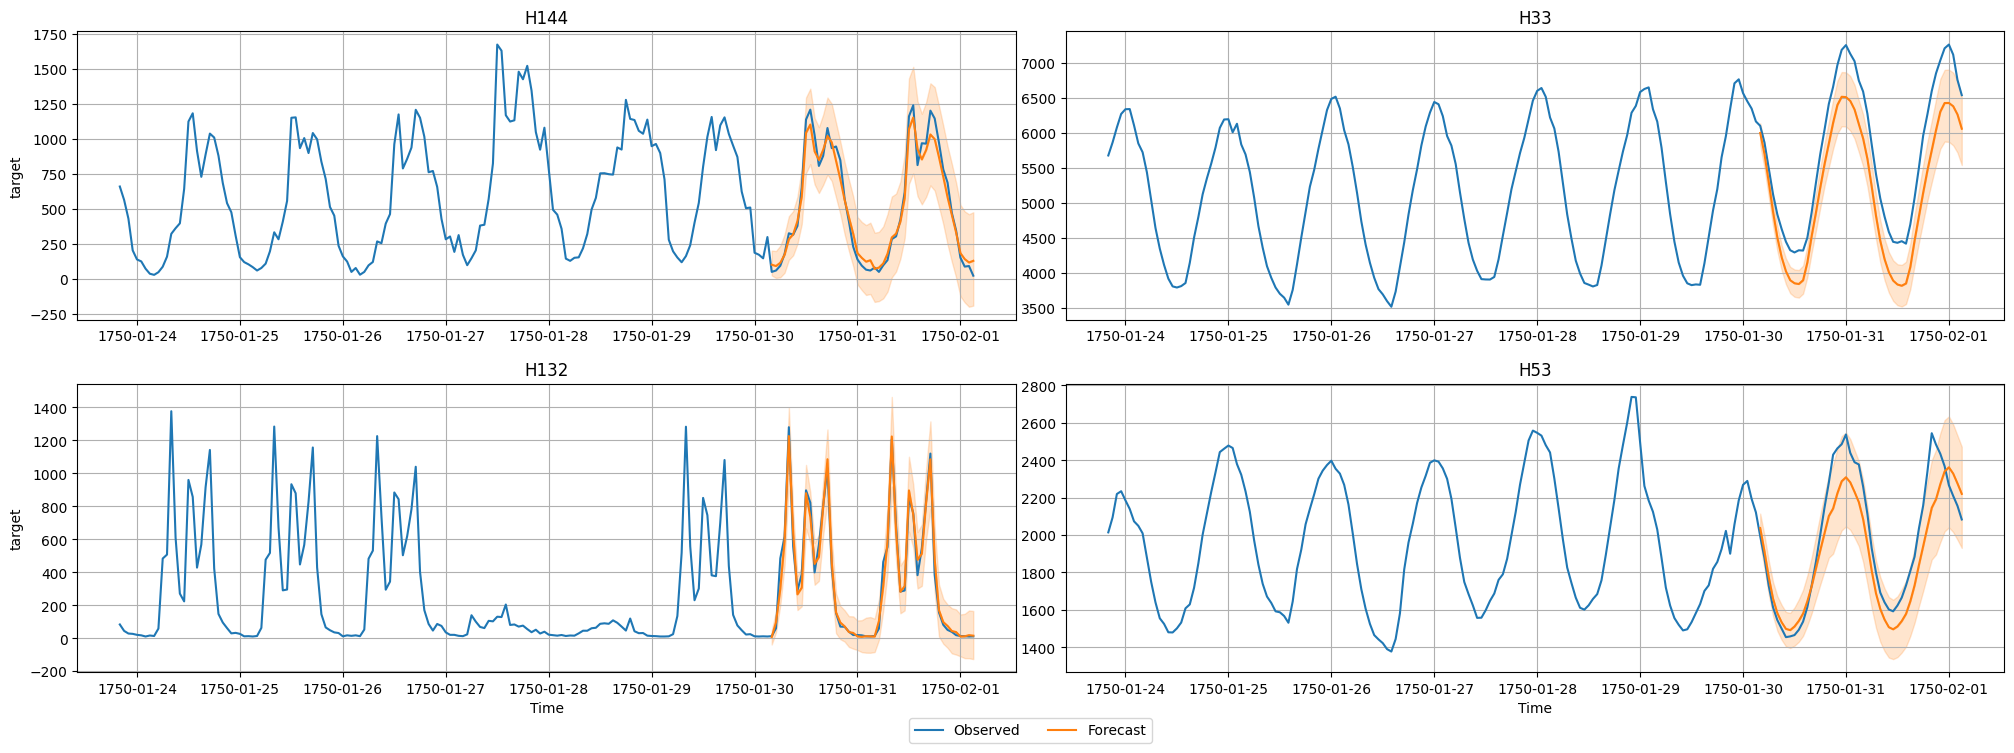

In [ ]:
test_data = TimeSeriesDataFrame.from_path(
    "https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_subset/test.csv"
)

predictor.plot(
    test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=200, max_num_item_ids=4
);

## 다양한 모델의 성능 평가

`leaderboard()` 메서드를 통해 AutoGluon이 학습한 각 모델의 성능을 볼 수 있습니다. 테스트 데이터 세트를 리더보드 함수에 제공하여 학습된 모델이 보이지 않는 테스트 데이터에서 얼마나 잘 수행되는지 확인합니다. 리더보드에는 내부 검증 데이터셋에서 계산된 검증 점수도 포함됩니다.

테스트 데이터에는 예측 기간(각 시계열의 마지막 `prediction_length` 값)과 과거 데이터(마지막 `prediction_last` 값을 제외한 모든 값)가 모두 포함됩니다.

AutoGluon 리더보드에서 점수가 높을수록 항상 더 나은 예측 성능에 해당합니다. 따라서 MASE 점수에 `-1`을 곱하여 "음수 MASE"가 높을수록 더 정확한 예측에 해당하도록 합니다.

In [ ]:
predictor.leaderboard(test_data)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.697607,-0.791366,13.339781,8.644861,0.386227,9
1,Chronos[bolt_small],-0.725739,-0.812070,1.574927,1.777771,0.084811,7
2,RecursiveTabular,-0.862797,-0.933874,0.488657,0.336368,3.245855,3
3,SeasonalNaive,-1.022854,-1.216909,0.133975,0.105367,0.061909,2
4,DirectTabular,-1.605700,-1.292127,0.160719,0.166876,3.339360,4
5,ETS,-1.806136,-1.966098,10.985835,6.286225,0.059151,5
6,Theta,-1.905367,-2.142551,0.287385,0.309614,0.060678,6
7,TemporalFusionTransformer,-2.065762,-2.403856,0.125047,0.077620,33.022607,8
8,Naive,-6.696079,-6.662942,0.119962,1.052629,0.064250,1


## 요약

`autogluon.timeseries`를 사용하여 M4 시간별 데이터셋에 대한 확률적 다단계 예측을 수행했습니다. 시계열 예측을 위한 AutoGluon의 고급 기능에 대해 알아보려면 [시계열 예측 - 심층 분석](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-indepth.html)을 확인하십시오.

# 마치며

이 튜토리얼에서는 AutoGluon의 기능의 일부만 다루었습니다. AutoGluon은 테이블, 멀티모달, 시계열 등 다양한 데이터 유형에 대해 손쉽게 AutoML을 적용할 수 있는 강력한 오픈소스 프레임워크입니다. 이 튜토리얼에서는 `TabularPredictor`, `MultiModalPredictor`, `TimeSeriesPredictor`의 기본 사용법을 예제를 통해 데이터 준비, 모델 학습, 예측, 평가까지의 워크플로우로 살펴보았습니다.

AutoGluon을 활용하면 머신러닝 모델 개발의 진입 장벽을 크게 낮출 수 있으며, 실험에서 프로덕션까지의 전환도 매우 간편합니다. 더 깊이 있는 활용법과 고급 기능은 공식 문서와 심화 튜토리얼을 참고해보시기 바랍니다.

## 참고 자료

- [AutoGluon 공식 문서](https://auto.gluon.ai/)
- [GitHub 저장소](https://github.com/autogluon/autogluon)